# Train Last Layer

In this NB I will try to figure out which layer is put on top of the pre-trained MovileNetV2, and train only that layer, as recommended by Chalet. 

## 1) Data pipeline

In [10]:
import numpy as np
from glob import glob
import os
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
## retrieve model
# model = keras.models.load_model('saved_models/')

## even a pre-trained model needs data:
# 1. Sort paths to files

IMAGE_SIZE = 224
path = '../beachlitter/'
images = sorted(glob(os.path.join(path, "images/*.jpg"))) # list of strings
masks = sorted(glob(os.path.join(path, "maskpngs/*.png"))) 

from sklearn.model_selection import train_test_split

def sort_paths(path, split=0.1):
    # PATH = "gs://dmcherney/beachlitter/"
    # glob(file_pattern) gives a list of strings satisfying the pattern
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "maskpngs/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)
    
    #shuffle with the same random seed to make sure masks stay with images.
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = sort_paths(path)

#2 functions to read images: path -> PIL -> array

def read_image(path): #takes in a path, gives out a np array
    path = path.decode() # neede because this function is in a tf pipe
    # open image
    im = PIL.Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE))
    # image to tensor
    im = tf.keras.utils.img_to_array(im, data_format=None, dtype='float32')
    # normalize image
    im = im/255.
    return im

def read_mask(path):
    path = path.decode() # neede because this function is in a tf pipe
    # open mask
    ma = PIL.Image.open(path).resize((IMAGE_SIZE,IMAGE_SIZE))
    # mask to tensor
    ma = tf.keras.utils.img_to_array(ma, data_format=None, dtype='float32')
    # change catagory numbers from 1 to 8 into 0 to 7
    ma[:,:,0] -= 1
    # one hot encode
    ma = to_categorical(ma[:,:,0],num_classes=8, dtype='float32')
    return ma

# arrays to tensorflow tensors:
def tf_parse(x, y): # takes in 2 paths, not lists
    def _parse(x, y): # takes in 2 paths
        x = read_image(x) 
        y = read_mask(y)
        return x, y # gives out 2 np.arrays

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32]) #takes in 2 paths, gives out 2 tf.tesors
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3]) # seems redundant, but for now it is bouble check
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 8])
    return x, y # tf.tesors 

# 3 organize data into tf dataset of tf tensors
def tf_dataset(x, y, batch=8): #takes in x : list of paths, y : list of paths
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

train_dataset = tf_dataset(train_x, train_y) # input: lists of filenames . Output: to batched tf datasets of parsed images
valid_dataset = tf_dataset(valid_x, valid_y)


In [11]:
# network architecture and fitting tools
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.callbacks import TensorBoard 
# from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import datetime


from tensorflow.keras.applications import MobileNetV2 

## 3) Modify the model: Freeze Encoder!

In [12]:

def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    # the pre-trained encoder
    encoder = MobileNetV2(input_tensor=inputs, 
                          weights="imagenet", # instead of randomized initial weights
                          include_top=False, # to fully connected softmax layer off. 
                          alpha=0.35) # proportionally decrease the number of filters in each layer. see paper.
    encoder.trainable = False
    skip_connection_names = ["input_image", "block_1_expand_relu", 
                             "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    # output of encoder is 16x16 
    
    # the decoder follows
    f = [16, 32, 48, 64] # the numbers of filters to use in skips traveling UP the U 
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    # output layer:
    x = Conv2D(8, (1, 1), padding="same")(x)
    x = Activation("softmax")(x)

    
    model = Model(inputs, x) # object created
    return model # object returned

model = model()
LR = 1e-4 #learning rate
opt = tf.keras.optimizers.Nadam(LR)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## 3) Train with the fit method

**Warning:** the following cell takes 5 hours of computation time on GCP's default settings of 15GB RAM CPU.

In [ ]:
# options first:
LR = 1e-4 #learning rate
opt = tf.keras.optimizers.Nadam(LR)
BATCH = 8 
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH
log_dir = "../saved_models/train_with_frozen_encoder/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # for tensorboard logs
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    # EarlyStopping(monitor='val_loss', 
    #               patience=5, 
    #               restore_best_weights=True # lets me save the model.
    #                      ),
    TensorBoard(log_dir=log_dir, histogram_freq=1, #for histogram computation each epoc 
                              )
]

#call fit
res = model.fit(
    train_dataset, # this actas as both X and y
    validation_data=valid_dataset,
    epochs = 50,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks_list,
    verbose=1
)

## 3.1) Saving training data to file

In [ ]:
import pandas as pd
scores= pd.DataFrame(data=res.history)
scores.to_csv('../saved_models/scores_train_last_layer.csv')
scores.sort_values(by='val_accuracy',ascending=False)

And to re-load training data

In [13]:
scores = pd.read_csv('../saved_models/scores_train_last_layer.csv' )
del scores['Unnamed: 0']

#For when you run further training epochs:

# scores = pd.concat([scores,pd.DataFrame(data=res.history)])
# scores # index now repeats.

# scores.reset_index(inplace=True)

# 4) plot val and acc


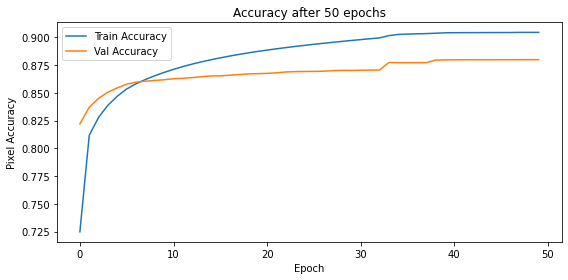

In [15]:
plt.figure(figsize=(8,4))
plt.plot(scores['accuracy'], label='Train Accuracy')
plt.plot(scores['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title(f'Accuracy after {len(scores)} epochs')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.tight_layout()
plt.savefig('../images/train_decoder.png', transparent=True);

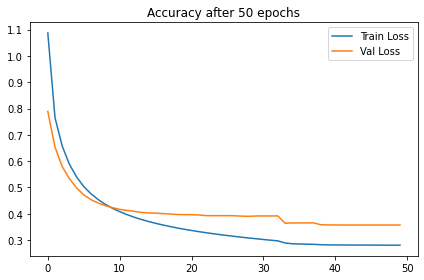

In [16]:
plt.plot(scores['loss'], label='Train Loss')
plt.plot(scores['val_loss'], label='Val Loss')
plt.legend()
plt.title(f'Accuracy after {len(scores)} epochs')
plt.tight_layout();

# 5) Tensorboard

In [18]:
%load_ext tensorboard
%tensorboard --logdir ../saved_models/train_with_frozen_encoder/logs/fit/

# 6) Save or Load the model
## 6.1) As keras model

In [ ]:
model.save('saved_models/train_with_frozen_encoder/')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('saved_models/train_with_frozen_encoder/')

## 6.2) As h5py

In [ ]:
model.save("saved_models/train_with_frozen_encoder/model.h5")

reconstructed_model = keras.models.load_model("saved_models/train_with_frozen_encoder/model.h5")

# 7) code for deployment

grab an image

In [ ]:
index = 9
im = PIL.Image.open(test_x[index]) # .resize((IMAGE_SIZE,IMAGE_SIZE)) How I'd usu get the size right
image = tf.keras.utils.img_to_array(im, data_format=None, dtype='float32') # in liew of tf.io.decode_image
input_shape = (224, 224)
image = tf.keras.preprocessing.image.smart_resize( image, input_shape, interpolation='bilinear')
image = image/255.
array = np.expand_dims(image, axis=0)


pred = reconstructed_model.predict(array)
pred = tf.keras.backend.argmax(pred[0,:,:,:],axis=-1) +1 
pred = np.reshape(pred, input_shape)

fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 2, 1 )
plt.axis('off')
plt.title('Your Beach Image',fontdict={'fontsize': 30})
plt.imshow(image)

fig.add_subplot(1, 2, 2 )
plt.axis('off')
plt.title('Where The Trash At',fontdict={'fontsize': 30})
plt.imshow(image)
plt.imshow(pred==1, alpha=0.3)

plt.tight_layout()
plt.savefig('mask.png')
